In [1]:
####### Analyse the BaseQTL results, with the following settings:
### Rhat and AI filtering as recommended
### Remove DpnII effects for SNPs and other SNPs in LD
### Restrict to only those SNP-gene pairs that are "truly distal" i.e. all proxy SNPs >= 10kb from gene promoter
#######

setwd("~/HRJ_monocytes/BaseQTL/findings_round2_dpnIICorrection/")
library(data.table)
library(dplyr)
library(stringr)
library(ggplot2)
library(tidyr)

#######
### To do:
### 1. Make a table of significant SNPs with gene targets and distances
### 2. Make an intersection with ATAC
### 3. Make a heatmap for CHiC, ATAC, expression and Blueprint, accounting for LD
### 4. Prepare for coloc.
#######

res <- fread("../elena_results/CHi-C/round2_refBias/all_stan.summary.txt")
doubleCheck <- fread("../../findmotifs/find_new_dpnII/snps_went_into_loopingQTL_analysis.DpnII.marked.REFALTseqs.PURGED.DISTAL.txt")
DpnII_purge <- fread("../../findmotifs/find_new_dpnII/SNPs_and_LD_proxies_Jan2020.DpnII.marked.REFALTseqs.txt")
trueDistal <- fread("~/eCHiC/design/final_design/V02_final_filtered_eqtls_illumina_july19_hg38_Jan20.txt")
all_info <- fread("../../eqtls/snps_went_into_loopingQTL_analysis_with_gene_targets.txt")

# Now reading in matrixeQTL resuls from Alex
resAlex <- readRDS("~/HRJ_monocytes/eqtls/eQTL_analysis/results/from_alex/RNA_cis_MatrixEQTLout.rds")

###### Process the stan summary to get SNPs and genes
res <- res[!int_id %like% "gwas"]
res[`2.5%` > 0 & `97.5%` > 0, Signif.95 := "yes"]
res[`2.5%` < 0 & `97.5%` < 0, Signif.95 := "yes"]
res[`2.5%` < 0 & `97.5%` > 0, Signif.95 := "no"]
res[, c("BaseQTL_SNP_hg19", "ENSG_ID", "GeneTemp") := tstrsplit(int_id, split = "_", keep = c(1:3))]
res[, Gene := sub("-[^-]+$", "", GeneTemp)]
#res <- res[, .(BaseQTL_SNP_hg19, ENSG_ID, Gene, log_mean_aFC, se_mean, sd, PEP, AI_estimate, Rhat, model, Signif.95, Signif.99)] # Keep all columns
res_info <- res[all_info, on = c(BaseQTL_SNP_hg19 = "hg19Proxy_ID", ENSG_ID = "ENSG_ID", Gene = "Gene"), nomatch = NULL]
length(unique(res_info$BaseQTL_SNP_hg19))
length(unique(res$BaseQTL_SNP_hg19)) # perfect!

#######

###### Perform filtering 

### filtering to remove DpnII effects 
DpnII_purge_remove <- DpnII_purge[all_dpn_ALT %like% "TRUE" | all_dpn_REF %like% "TRUE" | dpn_REF_in_baitRight == TRUE] # these are the SNPs to remove.
res_info_noDpn <- res_info[!BaseQTL_SNP_hg19 %in% DpnII_purge_remove$id]
length(unique(res_info$BaseQTL_SNP_hg19)) # 11624
length(unique(res_info_noDpn$BaseQTL_SNP_hg19)) # 11381

### filtering to remove proximal effects
res_info_noDpn_distal <- res_info_noDpn[hg19SNP_ID %in% trueDistal$hg19SNP_ID]
length(unique(res_info_noDpn_distal$BaseQTL_SNP_hg19)) # 9668

# double check against this file
#doubleCheck
DC <- res[doubleCheck, on = c(BaseQTL_SNP_hg19 = "hg19Proxy_ID", ENSG_ID = "ENSG_ID", Gene = "Gene"), 
            nomatch = NULL]
length(unique(DC$BaseQTL_SNP_hg19)) # yes, 9668!

## continue with res_info_noDpn_distal
#######

###### Get distances between SNPs and genes. Make Signif table
distances <- as.data.table(res_info_noDpn_distal %>% distinct(hg38Proxy_pos, ENSG_ID, Gene, TSS) %>% 
                          group_by(ENSG_ID, Gene) %>% mutate(meanTSS := mean(TSS)) %>% distinct(ENSG_ID, Gene, hg38Proxy_pos, meanTSS))
# join back together
res_dist <- res_info_noDpn_distal[distances, on = c("hg38Proxy_pos", "ENSG_ID", "Gene"), nomatch = NULL]

res_dist[, TSS := NULL]
res_dist[, meanTSS := as.numeric(meanTSS)]
res_dist[, hg38Proxy_pos := as.numeric(hg38Proxy_pos)]

res_dist[, SNP_promoter_dist := abs(hg38Proxy_pos - meanTSS)]
#quantile(res_dist$SNP_promoter_dist)
######

sig1 <- res_dist[Rhat < 1.01]
sig2 <- sig1[AI_estimate >= 0.4 | is.na(AI_estimate) & model == "NB"]
sig <- unique(sig2[Signif.95 == "yes"])
sig[, Chr := tstrsplit(BaseQTL_SNP_hg19, split = ":", keep =1, type.convert = T)]
setorder(sig, Chr)
nameorder <- moveme(names(sig), "Chr first")
sig2 <- sig[, ..nameorder]

fwrite(sig2, file = "./BaseQTL_CHiC_Filt_on_Dpn_Distal_Rhat_AI_allCols.txt", sep = "\t", quote = F, 
      row.names = F, col.names = T)

##### Also save a version of all results
res_dist[, Chr := tstrsplit(BaseQTL_SNP_hg19, split = ":", keep =1, type.convert = T)]
setorder(res_dist, Chr)
nameorder <- moveme(names(res_dist), "Chr first")
res_dist2 <- res_dist[, ..nameorder]
fwrite(res_dist2, file = "./BaseQTL_CHiC_Filt_on_Dpn_Distal_Rhat_AI_allCols_allResults.txt", sep = "\t", quote = F, 
      row.names = F, col.names = T)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] 11624

[1] 11624

[1] 11624

[1] 11381

[1] 9668

[1] 9668

In [4]:
length(unique(res_dist$hg19SNP_ID))
length(unique(res_dist$hg38Proxy_ID))
res_dist[, is_eQTL := hg38Proxy_ID == hg38SNP_ID]
same <- res_dist[is_eQTL == T]
length(unique(same$hg38Proxy_ID))
dif <- res_dist[is_eQTL == F]
length(unique(dif$hg38Proxy_ID))

In [4]:
library(data.table)
gues_in <- fread("~/HRJ_monocytes/leo_triplets/input/alex_inputs/CHiC_gene_locations.csv")
length(unique(gues_in$geneid))
gues_in

Warning message in fread("~/HRJ_monocytes/leo_triplets/input/alex_inputs/CHiC_gene_locations.csv"):
“Detected 4 column names but the data has 5 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 11152

V1,geneid,chr,left,right
<int>,<chr>,<chr>,<int>,<int>
1,1000319_ENSG00000026508_CD44,chr11,35146970,35147680
2,1000358_ENSG00000026508_CD44,chr11,35162449,35163957
3,1020975_ENSG00000151348_EXT2,chr11,44066424,44067717
4,1021057_ENSG00000110455_ACCS,chr11,44091905,44092020
5,1021060_ENSG00000110455_ACCS,chr11,44092384,44092731
6,1022131_ENSG00000085117_CD82,chr11,44525526,44525667
7,1022135_ENSG00000085117_CD82,chr11,44526194,44526445
8,1029652_ENSG00000110514_MADD,chr11,47234031,47234335
9,1029808_ENSG00000066336_SPI1,chr11,47276553,47276793


In [2]:
##### Get table of significant results
##### ADDING RSIDS IN THIS CHUNK TAKES SOME TIME!!!

### Add rsids
## Using file snps.dms, which is hg19 SNPs
snps <- fread("~/HRJ_monocytes/external_data/dbSNP/snp151Common_hg19.txt")
setnames(snps, c("V2", "V3", "V4"), c("chrom", "chromStart", "chromEnd"))
setkey(snps, chrom, chromStart, chromEnd)

# do an intersect on the sig contact QLTs themselves
sig2[, hg19Proxy_pos := tstrsplit(BaseQTL_SNP_hg19, split = ":", keep = 2, type.convert = T)]
sig2[, hg19Proxy_pos0 := hg19Proxy_pos-1]
sig2[, chrom := paste0("chr", Chr)]

rsids <- snps[sig2, on = c(chrom = "chrom", chromStart = "hg19Proxy_pos0"), nomatch = NULL]
rsids[, c("V1", "chromStart", "chromEnd", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13", 
         "V14", "V15", "V16", "V17", "V18", "V19", "V20", "V21", "V22", "V23", "V24", "V25", "V26") := NULL]
setnames(rsids, "V5", "rsid")
fwrite(rsids, file = "./BaseQTL_CHiC_Filt_on_Dpn_Distal_Rhat_AI_rsids_allCols.txt", sep = "\t",
       quote = F, row.names = F, col.names= T)


In [2]:
## Look at numbers for the paper
setwd("~/HRJ_monocytes/BaseQTL/findings_round2_dpnIICorrection/")

library(data.table)
sig2 <- fread("./BaseQTL_CHiC_Filt_on_Dpn_Distal_Rhat_AI.txt")
rsids <- fread("./BaseQTL_CHiC_Filt_on_Dpn_Distal_Rhat_AI_rsids.txt")
#str(rsids)
length(unique(rsids$BaseQTL_SNP_hg19))
length(unique(sig2$BaseQTL_SNP_hg19))
length(unique(sig2$Gene))
length(unique(sig2$hg19SNP_ID))
sig99 <- sig2[Signif.99 == "yes"]
length(unique(sig99$BaseQTL_SNP_hg19))

rsids[, inverse_norm_approx := 1-(1-pnorm(0,abs(log_mean_aFC), sd, lower.tail=FALSE))]

## For THBS1, did we test the lead eQTL?
#sig2[Gene == "THBS1"]
#res[BaseQTL_SNP_hg19 == "15:39604835:C:T"]
res <- fread("../elena_results/CHi-C/round2_refBias/all_stan.summary.txt")
#res[int_id %like% "15:39604835:C:T"]
#res[int_id %like% "7:26135404:C:T"] # chr7:25,998,806-26,231,173 # for this one we also wanted to test CBX3 and it was only sig at 50% (maybe 90% though??) - check it. log mean aFC -0.32. We found sig for NFE2L3, log mean aFC -0.399.
#res[int_id %like% "19:54551115:G:T"] # chr19:54,036,654-54,121,092 # for this one we also wanted to test OSCAR and it was close! - OSCAR and TFPT. log mean aFC OSCAR -0.343 and log mean aFC TFPT -0.604. Might be nice to illustrate.

2^(-0.604)
# get original dataset to ask if there were any other genes (proximal) in the first place
orig <- fread("~/eCHiC/design/source/cd14_eqtls_no_freq.txt")
orig_small <- orig[, .(hgnc, snp_pos, snp_id, ensembl_gid)]

sig2_small <- unique(sig2[, .(ENSG_ID, Gene, hg19SNP_ID)])
sorig <- orig_small[sig2_small, on = c(snp_id = "hg19SNP_ID")]
#sorig


# Adding the ATAC BaseQTL data, combine with CHiC
### To begin with, just take exactly the same SNPs (not looking in LD)
### How many of the SNPs intersected the CHi-C loci where we looked for looping effects?
at <- fread("~/HRJ_monocytes/BaseQTL/elena_results/ATAC//round2_refBias/atac_stan.summary.txt")
atSig <- at[Signif.99 == "yes" & Rhat < 1.01 & AI_estimate >= 0.4 | Signif.99 == "yes" & Rhat < 1.01 & is.na(AI_estimate) & model == "NB"]
atSig[, c("featStart", "featEnd", "hg19Proxy_ID") := tstrsplit(int_id, split = "-")]
atSig[, c("Chr", "featStart") := tstrsplit(featStart, split = ":")]
atSig[, c("hg19Proxy_pos", "REF", "ALT") := tstrsplit(hg19Proxy_ID, split = ":", keep = c(2,3,4), type.convert = T)]
atSig[, chrom := paste0("chr", Chr)]
atSig[, hg19Proxy_pos0 := hg19Proxy_pos-1]
length(unique(atSig$hg19Proxy_ID))
doubleCheck <- fread("../../findmotifs/find_new_dpnII/snps_went_into_loopingQTL_analysis.DpnII.marked.REFALTseqs.PURGED.DISTAL.txt")
setkey(atSig, hg19Proxy_ID)

### NUMBERS FOR THE PAPER: combining with the eQTLs that we tried to capture. This is accounting for LD, because we combine based on a SNP in LD with the eQTL in each case.
atSig_allinfo <- doubleCheck[atSig, on = c("hg19Proxy_ID"), nomatch = NULL]

# How many of the ATAC QTLs were the lead eQTL???
lead <- atSig_allinfo[hg19SNP_ID == hg19Proxy_ID]
no_ATAC_eQTLs <- length(unique(lead$hg19Proxy_ID))
print(paste0("The number of ATAC QTLs that were also lead eQTLs is ", no_ATAC_eQTLs))

# How many of the ATAC QTLs were in LD with the lead eQTL?
no_ATAC_proxies <- length(unique(atSig_allinfo$hg19Proxy_ID))
print(paste0("The number of ATAC QTLs in total that were at eQTLs accounting for LD is ", no_ATAC_proxies))

# How many of the eQTLs were tagged by an ATAC QTL, accounting for LD?
no_eQTL_ATAC <- length(unique(atSig_allinfo$hg19SNP_ID))
print(paste0("The number of eQTLs that were also ATAC QTLs, accounting for LD, is ", no_eQTL_ATAC))

# How many genes were involved?
no_genes <- length(unique(atSig_allinfo$ENSG_ID))
print(paste("The number of eGenes associated with ATAC QTLs was ", no_genes))

print("And the tested numbers of A) proxies, B) eQTLs and C) Genes in the BAseQTL CHiC modality were:")
length(unique(doubleCheck$hg19Proxy_ID))
length(unique(doubleCheck$hg19SNP_ID))
length(unique(doubleCheck$ENSG_ID))

### How many sig looping QTLs were also ATAC QTLs? 
#str(atSig_allinfo)
#str(sig2)
atSig_allinfoSmall <- unique(atSig_allinfo[, .(hg19Proxy_ID, Signif.99, hg19SNP_ID, log_mean_aFC, featStart, featEnd)])
setnames(atSig_allinfoSmall, c("Signif.99", "log_mean_aFC", "hg19SNP_ID", "featStart", "featEnd"), 
         c("at_Signif.99", "at_log_mean_aFC", "at_hg19SNP_ID", "at_featStart", "at_featEnd"))
#atSig_allinfoSmall
sig99 <- rsids[Signif.99 == "yes"]
chic_at <- sig99[atSig_allinfoSmall, on = c(BaseQTL_SNP_hg19 = "hg19Proxy_ID"), nomatch = NULL] # Here joining on exactly the same SNP

length(unique(chic_at$BaseQTL_SNP_hg19))
length(unique(chic_at$hg19SNP_ID))
length(unique(chic_at$Gene))
setnames(chic_at, "log_mean_aFC", "chic_log_mean_aFC")
length(unique(sig99$BaseQTL_SNP_hg19))
length(unique(sig99$Gene))
length(unique(sig99$hg19SNP_ID))
#length(unique(sig2$BaseQTL_SNP_hg19))
#length(unique(sig2$Gene))
#length(unique(sig2$hg19SNP_ID))

[1] 29

[1] 29

[1] 15

[1] 16

[1] 19

[1] 0.6579273

[1] 34900

[1] "The number of ATAC QTLs that were also lead eQTLs is 104"
[1] "The number of ATAC QTLs in total that were at eQTLs accounting for LD is 994"
[1] "The number of eQTLs that were also ATAC QTLs, accounting for LD, is 223"
[1] "The number of eGenes associated with ATAC QTLs was  216"
[1] "And the tested numbers of A) proxies, B) eQTLs and C) Genes in the BAseQTL CHiC modality were:"


[1] 12295

[1] 1197

[1] 1074

[1] 10

[1] 7

[1] 6

[1] 19

[1] 9

[1] 10

In [4]:

######### Now, join with the ATAC data accounting for LD. For this, combine based on all SNPs in LD with each looping QTL (not just the eQTL or the contact QTL itself.)
prox <- fread("~/eCHiC/design/LD/SNPs_and_LD_proxies_Jan2020.txt")
prox_small <- as.data.table(prox[, .(hg19SNP_ID, hg19Proxy_ID, ENSG_ID, Beta)] %>% distinct())
resprox <- sig99[prox_small, on = c("hg19SNP_ID", "ENSG_ID"), nomatch = NULL] # gets the eQTL for each of the baseQTL contact QTLs.
length(unique(resprox$BaseQTL_SNP_hg19))
length(unique(resprox$hg19Proxy_ID))

# now connect with ATAC data based on the hg19Proxy_ID, to get all LD effects
chic_at_LD <- resprox[atSig_allinfoSmall, on = "hg19Proxy_ID", nomatch = NULL]
length(unique(chic_at_LD$BaseQTL_SNP_hg19))
length(unique(chic_at_LD$hg19SNP_ID))
length(unique(chic_at_LD$Gene))
setnames(chic_at_LD, "log_mean_aFC", "chic_log_mean_aFC")

chic_at_LD_tab <- atSig_allinfoSmall[resprox, on = c(hg19Proxy_ID = "hg19Proxy_ID"), allow.cartesian = T]
setnames(chic_at_LD_tab, c("log_mean_aFC"), c("chic_log_mean_aFC"))

chic_at_LD_tab_small <- unique(chic_at_LD_tab[, .(BaseQTL_SNP_hg19, hg19Proxy_ID, hg19SNP_ID, rsid, ENSG_ID, Gene, chic_log_mean_aFC, at_log_mean_aFC, hrc_hg38Proxy_ID, at_featStart, at_featEnd, Beta, hg38Dpn_start, hg38Dpn_end)])

str(chic_at_LD_tab_small) # check that we retainined information on the DpnII location.

[1] 19

[1] 224

[1] 17

[1] 8

[1] 7

Classes ‘data.table’ and 'data.frame':	733 obs. of  14 variables:
 $ BaseQTL_SNP_hg19 : chr  "4:76816143:G:A" "4:76817412:G:A" "4:76816143:G:A" "4:76817412:G:A" ...
 $ hg19Proxy_ID     : chr  "4:76805267:G:C" "4:76805267:G:C" "4:76809074:T:C" "4:76809074:T:C" ...
 $ hg19SNP_ID       : chr  "4:76819033:A:G" "4:76819033:A:G" "4:76819033:A:G" "4:76819033:A:G" ...
 $ rsid             : chr  "rs13150842" "rs11731367" "rs13150842" "rs11731367" ...
 $ ENSG_ID          : chr  "ENSG00000138744" "ENSG00000138744" "ENSG00000138744" "ENSG00000138744" ...
 $ Gene             : chr  "NAAA" "NAAA" "NAAA" "NAAA" ...
 $ chic_log_mean_aFC: num  0.371 0.27 0.371 0.27 0.371 ...
 $ at_log_mean_aFC  : num  NA NA NA NA NA ...
 $ hrc_hg38Proxy_ID : chr  "4:75894990:G:A" "4:75896259:G:A" "4:75894990:G:A" "4:75896259:G:A" ...
 $ at_featStart     : chr  NA NA NA NA ...
 $ at_featEnd       : chr  NA NA NA NA ...
 $ Beta             : num  0.243 0.243 0.243 0.243 0.243 ...
 $ hg38Dpn_start    : int  75894747 75896

In [5]:
### Now we should filter to look at the directionality based on the closest ATAC-seq peak, and only if it is within 5kb of the contact QTL.

### aside:
#chic_at_LD_tab_small[Gene == "KCNK13"]
# really interestingly, there is an opposing direction on ATAC for a SNP closer to the eQTL. i.e., the lead eQTL has an opposing effect not only on gene expression but also on ATAC.
# did we not profile the lead eQTL for ATAC?
#at[int_id %like% "14:90572484:T:C"] # no we did not

# OK, make a table to show the mean effect.
# remove the line where we have opposing direction in same LD block and double check that the rest are same dir.
chic_at_LD_tab_small2 <- chic_at_LD_tab_small[hg19Proxy_ID != "14:90565182:G:A"] # this makes sense because for the contact QTL there there was a direct overlap with an ATAC QTL with the same direction of effect on that peak.

chic_at_LD_tab_small2[chic_log_mean_aFC >0 & at_log_mean_aFC >0 | chic_log_mean_aFC <0 & at_log_mean_aFC <0, at_chic_dir := "same"]
chic_at_LD_tab_small2[chic_log_mean_aFC >0 & at_log_mean_aFC <0 | chic_log_mean_aFC <0 & at_log_mean_aFC >0, at_chic_dir := "opposing"]
#chic_at_LD_tab_small2[at_chic_dir == "opposing"] # none.
#chic_at_LD_tab_small2[Gene == "C7orf50"]
chic_at_LD_tab_small2[hg19Proxy_ID %like% "GATC"] 


chic_at_LD_tab_small3 <- as.data.table(chic_at_LD_tab_small2 %>% group_by(BaseQTL_SNP_hg19, hg19SNP_ID, rsid, ENSG_ID, Gene, chic_log_mean_aFC, hrc_hg38Proxy_ID, Beta, hg38Dpn_start, hg38Dpn_end) %>%
                                      summarize(average_at_log_aFC = mean(at_log_mean_aFC, na.rm = T)))

## save this table!
## note will need to average the ATAC effect and fix KCNK13 again.
fwrite(chic_at_LD_tab_small2, file = "./AT_CHiC_with_LD_SNPs_and_MikBetas_Signif99.txt", sep = "\t", quote = F, row.names = F, col.names = T)
       
#unique(chic_at_LD_tab_small3[, .(rsid, Gene, chic_log_mean_aFC, average_at_log_aFC, Beta)])

## Making table for Zak: sort out KCNK13

###################################################################
chic_at_LD_tab_small3[Gene == "KCNK13", Beta := 0.41]
###################################################################


setnames(chic_at_LD_tab_small3, c("BaseQTL_SNP_hg19", "Beta"), c("BaseQTL_hg19Proxy_ID", "Gene_Expression_Beta"))
chic_at_LD_tab_small3[, BaseQTL_feature := paste(BaseQTL_hg19Proxy_ID, ENSG_ID, Gene, sep = "_")]
chic_at_LD_tab_small3[, c("hg19SNP_ID", "Gene", "ENSG_ID") := NULL]
chic_at_LD_tab_small3[chic_log_mean_aFC >0 & average_at_log_aFC >0 | chic_log_mean_aFC <0 & average_at_log_aFC <0, ATAC_CHiC_direction := "same"]
chic_at_LD_tab_small3[chic_log_mean_aFC >0 & average_at_log_aFC <0 | chic_log_mean_aFC <0 & average_at_log_aFC >0, ATAC_CHiC_direction := "opposing"]
chic_at_LD_tab_small3[chic_log_mean_aFC >0 & Gene_Expression_Beta >0 | chic_log_mean_aFC <0 & Gene_Expression_Beta <0, Gene_CHiC_direction := "same"]
chic_at_LD_tab_small3[chic_log_mean_aFC >0 & Gene_Expression_Beta <0 | chic_log_mean_aFC <0 & Gene_Expression_Beta >0, Gene_CHiC_direction := "opposing"]


#chic_at_LD_tab_small3


chic_at_LD_tab_small3[, abs_chic_log_mean_aFC := abs(chic_log_mean_aFC)]
chic_at_LD_tab_small3[chic_log_mean_aFC > 0, relative_abs_ATAC_mean_aFC := average_at_log_aFC]
chic_at_LD_tab_small3[chic_log_mean_aFC < 0, relative_abs_ATAC_mean_aFC := 0-average_at_log_aFC]
chic_at_LD_tab_small3[chic_log_mean_aFC > 0, relative_Gene_Expression_Beta := Gene_Expression_Beta]
chic_at_LD_tab_small3[chic_log_mean_aFC < 0, relative_Gene_Expression_Beta := 0-Gene_Expression_Beta]

chic_at_LD_tab_small4 <- unique(chic_at_LD_tab_small3[, .(BaseQTL_hg19Proxy_ID, rsid, hrc_hg38Proxy_ID, abs_chic_log_mean_aFC, 
                                                         relative_abs_ATAC_mean_aFC, relative_Gene_Expression_Beta, 
                                                         ATAC_CHiC_direction, Gene_CHiC_direction, BaseQTL_feature)])

#chic_at_LD_tab_small4
fwrite(chic_at_LD_tab_small4, file = "./CHiC_BaseQTL_Signif99_ATAC_Gene_directions.txt", 
      sep = "\t", quote = F, row.names =F, col.names = T)



BaseQTL_SNP_hg19,hg19Proxy_ID,hg19SNP_ID,rsid,ENSG_ID,Gene,chic_log_mean_aFC,at_log_mean_aFC,hrc_hg38Proxy_ID,at_featStart,at_featEnd,Beta,hg38Dpn_start,hg38Dpn_end,at_chic_dir
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>


`summarise()` has grouped output by 'BaseQTL_SNP_hg19', 'hg19SNP_ID', 'rsid',
'ENSG_ID', 'Gene', 'chic_log_mean_aFC', 'hrc_hg38Proxy_ID', 'Beta',
'hg38Dpn_start'. You can override using the `.groups` argument.


          rsid   Gene chic_log_mean_aFC at_log_mean_aFC
 1:  rs3006562   SVIL         0.9863521       1.2773598
 2:  rs1152443 KCNK13         0.5761226       1.7878565
 3:   rs998005  THBS1         0.6081494       0.5844153
 4:  rs1354596  THBS1         0.4556128       0.3724707
 5:   rs894043  THBS1         0.7490782       0.4070000
 6:   rs894042  THBS1         0.7070719       0.4428045
 7: rs10415777   TFPT        -0.6040825      -0.9411305
 8: rs13150842   NAAA         0.3708849       0.4036246
 9: rs11731367   NAAA         0.2695567       0.3901208
10: rs35257100 NFE2L3        -0.3993956      -1.1185851


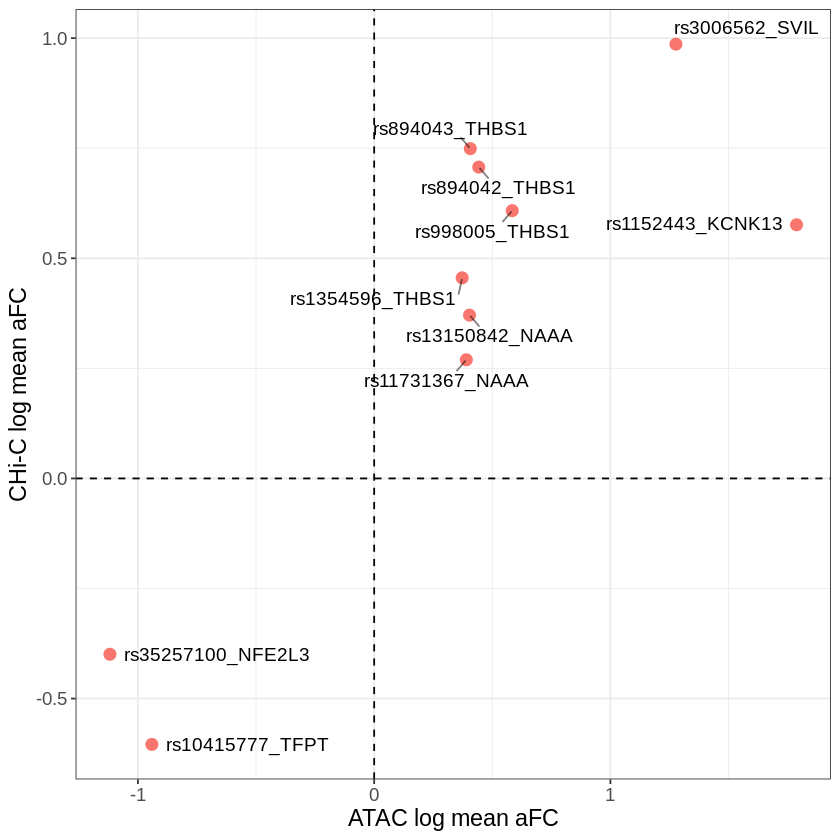

In [7]:
### Make a plot of effect correlations (this one does not account for LD)
library(ggrepel)

make_corPlot <- function(dt) {
  ggplot(dt, aes(x = at_log_mean_aFC, y = chic_log_mean_aFC, col = "red")) + 
  geom_point(size = 3) + 
  xlab("ATAC log mean aFC") +
  ylab("CHi-C log mean aFC") +
  #xlim(-0.2, 0.2) +
  #ylim(-0.4, 0.4) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  geom_vline(xintercept = 0, linetype = "dashed") +
    geom_text_repel(aes(label= as.character(ID)),
                  angle = 0, size = 4, max.time = 120.0, color = "black", force = 0.5, force_pull = 0.1,
                  segment.alpha = 0.5, box.padding = 0.5, max.overlaps = Inf) +
    theme_bw() +
  theme(
    legend.position="none",
    text = element_text(size = 14)) 
}
chic_at[, ID := paste(rsid, Gene, sep = "_")]
toplot <- unique(chic_at[, .(at_log_mean_aFC, chic_log_mean_aFC, ID)])

#pdf(file = "chic_vs_ATAC_99_corplot_rsids.pdf", width = 6.5, height = 6.5)
make_corPlot(toplot)
#dev.off()

## all go in the same direction.

## Save the source data.
source_dat <- unique(chic_at[, .(rsid, Gene, chic_log_mean_aFC, at_log_mean_aFC)])
print(source_dat)
fwrite(source_dat, file = "~/HRJ_monocytes/paper/source_data/Figure3B_CHiC_AT_corr.txt", 
      sep = "\t", quote = F, row.names = F, col.names = T)


In [61]:
### Start to integrate gene expression and the Blueprint data. 
### Taking code from "~/HRJ_monocytes/BaseQTL/scripts/explore_results_34reps.Rmd"

### First, I was checking genotypes. Just putting code here for keeping.
### Also checking direction in Vosa versus our own Matrix QTL. We had 85% in same direction (See bottom of this chunk)
res <- fread("./BaseQTL_CHiC_Filt_on_Dpn_Distal_Rhat_AI.txt")
# Zero means homozygous REF. 1 means heterozygous. And 2 means homozygous ALT.
# Ref and Alt are presumably the same as in the genotypes file, which is the same as in the HRC. What I need to do is connect the eQTL results with this. Check our eQTL analysis.
orig <- fread("~/eCHiC/design/source/CD14_eqtls_Mikhail.txt", sep = "\t")
orig <- separate(orig, snp_id, into = c("Chr", "hg19SNP_pos", "origREF", "origALT"), sep = ":", remove = FALSE)
orig$freqs <- gsub("\\[|\\]", "", orig$`allele counts`) # remove weird square brackets
orig$freqs2 <- str_squish(orig$freqs) # remove extra spaces
orig <- separate(orig, freqs2, into = c("counts_homREF", "counts_HET", "counts_homALT"), sep = " ")
orig[, c("allele counts", "freqs") := NULL]
orig[counts_homREF < counts_homALT, minor_allele_Vosa := origREF]
orig[counts_homALT < counts_homREF, minor_allele_Vosa := origALT]
orig[hgnc == "KCNK13"]
orig[hgnc == "C7orf50", .(snp_pos, beta, p_value)]
orig[snp_pos == "1212211", .(snp_pos, beta, p_value)]


Warning message in `[.data.table`(orig, counts_homREF < counts_homALT, `:=`(minor_allele_Vosa, :
“Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved.”


probe_id,hgnc,chrom,snp_pos,snp_id,Chr,hg19SNP_pos,origREF,origALT,beta,⋯,indep_signal_i,ensembl_gid,n_samples,maf,hwe_pvalue,imputation_score,counts_homREF,counts_HET,counts_homALT,minor_allele_Vosa
<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
990112,KCNK13,14,90572484,14:90572484:T:C,14,90572484,T,C,-0.119812,⋯,0,ENSG00000152315,5327,0.3343653,0.6368283,0.980785,705,625,150,C


snp_pos,beta,p_value
<int>,<dbl>,<dbl>
1070395,-0.09085917,2.930902e-16
1170458,-0.17255314,5.301339e-10
1212211,0.05767463,1.872238e-11


snp_pos,beta,p_value
<int>,<dbl>,<dbl>
1212211,0.05767463,1.872238e-11


In [39]:
####### Now we can assign the ALT allele to the beta
### Go back to using the original dataset.
orig[, c("counts_homREF", "counts_HET", "counts_homALT", "minor_allele_Vosa"):= NULL]
setnames(orig, "beta", "eQTL_beta_wrt_alt", skip_absent=TRUE )

### Compare with our eQTL data - copying over some code from the matrixeQTL analysis.
### UPDATE: use Alex's matrixQTL results instead
our_eqtls <- as.data.table(resAlex)
## The IDs for our eQTL analysis are in hg19 (double checked).
## In this analysis, 0 means homALT, 1 means HET and 2 means REF. The analysis beta is based off the increasing no. ie REF.
# in Alex's, the beta is based off increasing ALT, not REF.
hg38 <- fread("~/HRJ_monocytes/eqtls/eQTL_analysis/exploration/original_mono_eQTLs_hg38pos_Mikhail.txt")

### Checking again the condordance between oriignal snp beta and ours. 
# prev code.
#names(our_eqtls)[2] = "ensembl_gid"
#names(our_eqtls)[3] = "new_eQTL_beta_wrt_REF" 
#names(our_eqtls)[4] = "new_eQTL_t-stat"
#names(our_eqtls)[5] = "new_eQTL_p-value"

our_eqtls[, ensembl_gid := tstrsplit(gene, split = "_", keep = 1)]

setkey(our_eqtls, SNP, ensembl_gid)
joi <- orig[our_eqtls, on = c(snp_id = "SNP", ensembl_gid = "ensembl_gid"), nomatch = NULL]
samedir <- joi[(eQTL_beta_wrt_alt > 0 & beta > 0) | (eQTL_beta_wrt_alt < 0 & beta < 0) ] # there was actually an error here before as well.
length(unique(joi$snp_id))
length(unique(samedir$snp_id))
# 4836/6161 = 78% of those that we could match, based on SNP and gene ID, are in the same direction. 

sig_eqtl <- joi[i.FDR < 0.01]
sig_samedir <- sig_eqtl[(eQTL_beta_wrt_alt > 0 & beta > 0) | (eQTL_beta_wrt_alt < 0 & beta < 0)]
length(unique(sig_eqtl$snp_id))
length(unique(sig_samedir$snp_id))
# 98% at high confidence
# 375/383


ERROR: Error in eval(expr, envir, enclos): object 'orig' not found


In [42]:
375/383

resAlex <- as.data.table(readRDS("~/HRJ_monocytes/eqtls/eQTL_analysis/results/from_alex/RNA_cis_MatrixEQTLout.rds"))
str(resAlex)

[1] 0.9791123

Classes ‘data.table’ and 'data.frame':	19224815 obs. of  6 variables:
 $ SNP    : chr  "4:141910489:T:A" "4:141912170:A:G" "4:141915484:G:C" "4:141915795:C:T" ...
 $ gene   : chr  "ENSG00000170153_RNF150" "ENSG00000170153_RNF150" "ENSG00000170153_RNF150" "ENSG00000170153_RNF150" ...
 $ t.stat : num  39.7 39.7 39.7 39.7 39.7 ...
 $ p.value: num  7.78e-27 7.78e-27 7.78e-27 7.78e-27 7.78e-27 ...
 $ FDR    : num  1.03e-21 1.03e-21 1.03e-21 1.03e-21 1.03e-21 ...
 $ beta   : num  1.9 1.9 1.9 1.9 1.9 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [45]:
resAlex[gene %like% "C7orf50" & SNP == "7:1210755:C:T"]
resAlex[gene %like% "C7orf50" & SNP == "7:1210898:G:A"]
resAlex[gene %like% "C7orf50" & SNP == "7:1210987:G:A"]
resAlex[gene %like% "C7orf50" & SNP == "7:1211978:C:G"]
resAlex[gene %like% "C7orf50" & SNP == "7:1212211:C:A"]

resAlex[FDR <= 0.05]

SNP,gene,t.stat,p.value,FDR,beta
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
7:1210755:C:T,ENSG00000146540_C7orf50,-1.281004,0.2103421,0.9052542,-0.03350691


SNP,gene,t.stat,p.value,FDR,beta
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
7:1210898:G:A,ENSG00000146540_C7orf50,-1.544069,0.1334151,0.8639835,-0.04078862


SNP,gene,t.stat,p.value,FDR,beta
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
7:1210987:G:A,ENSG00000146540_C7orf50,-1.281004,0.2103421,0.9052542,-0.03350691


SNP,gene,t.stat,p.value,FDR,beta
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
7:1211978:C:G,ENSG00000146540_C7orf50,-1.281004,0.2103421,0.9052542,-0.03350691


SNP,gene,t.stat,p.value,FDR,beta
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
7:1212211:C:A,ENSG00000146540_C7orf50,-1.544069,0.1334151,0.8639835,-0.04078862


SNP,gene,t.stat,p.value,FDR,beta
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
4:141910489:T:A,ENSG00000170153_RNF150,39.71473,7.782883e-27,1.031893e-21,1.902404
4:141912170:A:G,ENSG00000170153_RNF150,39.71473,7.782883e-27,1.031893e-21,1.902404
4:141915484:G:C,ENSG00000170153_RNF150,39.71473,7.782883e-27,1.031893e-21,1.902404
4:141915795:C:T,ENSG00000170153_RNF150,39.71473,7.782883e-27,1.031893e-21,1.902404
4:141916582:T:G,ENSG00000170153_RNF150,39.71473,7.782883e-27,1.031893e-21,1.902404
4:141916743:C:A,ENSG00000170153_RNF150,39.71473,7.782883e-27,1.031893e-21,1.902404
4:141916891:T:C,ENSG00000170153_RNF150,39.71473,7.782883e-27,1.031893e-21,1.902404
4:141916900:A:G,ENSG00000170153_RNF150,39.71473,7.782883e-27,1.031893e-21,1.902404
4:141917068:T:C,ENSG00000170153_RNF150,39.71473,7.782883e-27,1.031893e-21,1.902404


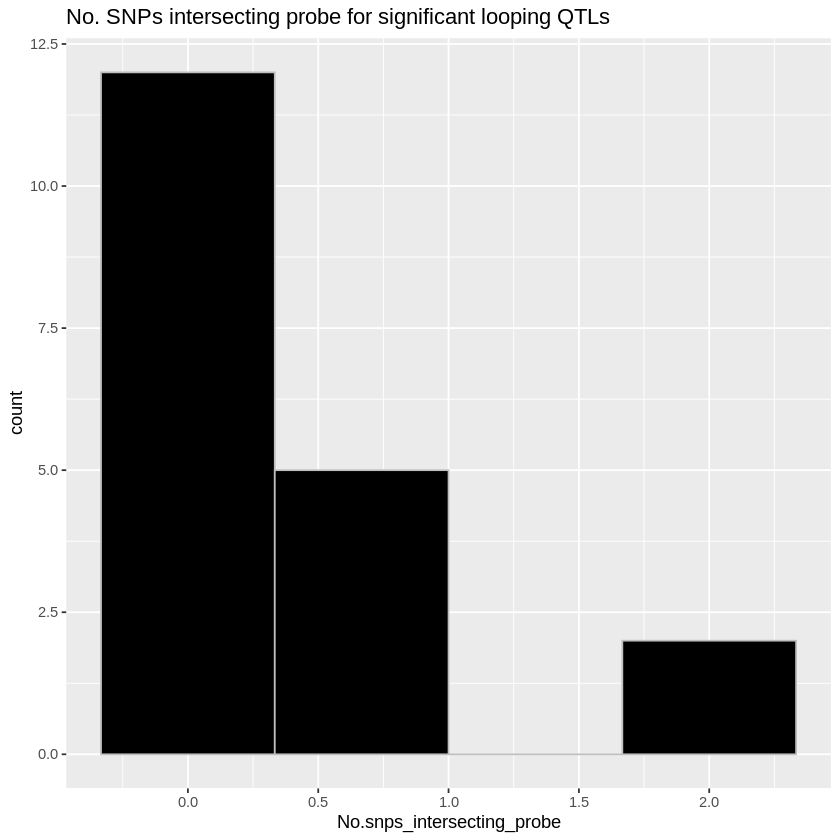

In [6]:
### Aside: check how many SNPs were in the probe each time
# In this file, the Beta is from the original CD14 table and is wrt ALT.
# log_mean_aFC is also wrt ALT.
##### Checking that the probes did not have 4+ SNPS in them.
baits <- fread("~/spivakov/Design/Human_eQTL_CHiC_DpnII_hg38/eCHiC_grch38.baitmap") # Don't need this
snps_in_probes <- fread("~/HRJ_monocytes/AS_CHiC/capture_efficiency_check/SNPs_in_probes.txt")
rmap <- fread("~/spivakov/Design/Human_eQTL_CHiC_DpnII_hg38/hg38_dpnII.rmap")
names(rmap) = c("chr", "hg38Dpn_start", "hg38Dpn_end", "DpnID")
resprox_dpn <- resprox[rmap, on = c("hg38Dpn_start", "hg38Dpn_end"), nomatch = NULL] # here getting the dpn IDs

sig_wSNPs_check <- snps_in_probes[resprox_dpn, on = "DpnID"] #### if not intersecting, there were zero
sig_wSNPs_check[is.na(sig_wSNPs_check)] <- 0
to_plottt <- unique(sig_wSNPs_check[, .(BaseQTL_SNP_hg19, No.snps_intersecting_probe)])
p <- ggplot(to_plottt, aes(x = No.snps_intersecting_probe))
p + geom_histogram(bins = 4, fill="black", col="grey") + ggtitle("No. SNPs intersecting probe for significant looping QTLs")
# zero to 2.

#resprox

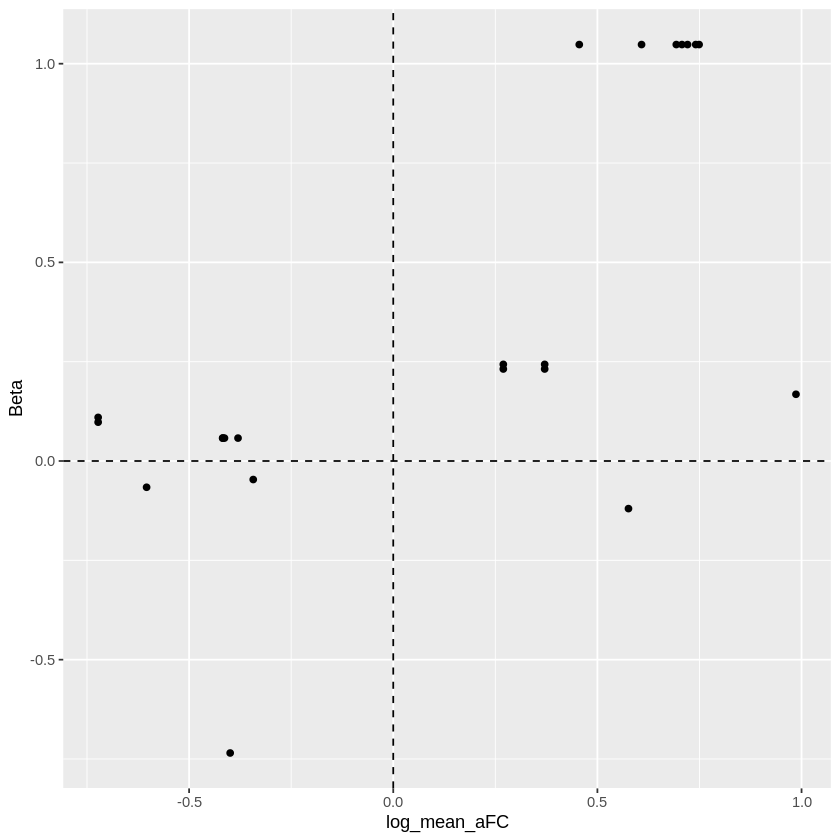

In [7]:
# checking betas expression versus chic
# REF and ALT should match, because we matched based on the full hg19SNP_ID
# In BaseQTL analysis, log_mean_aFC refers to the alt allele, as does the original Vosa table.

resprox_dpn[log_mean_aFC < 0 & Beta < 0, direction_eQTLvsLooping := "same"] # These are same dir
resprox_dpn[log_mean_aFC > 0 & Beta > 0, direction_eQTLvsLooping := "same"] # These are same dir
resprox_dpn[log_mean_aFC < 0 & Beta > 0, direction_eQTLvsLooping := "different"] # These are dif dir
resprox_dpn[log_mean_aFC > 0 & Beta < 0, direction_eQTLvsLooping := "different"] # These are dif dir

pl <- ggplot(plott, aes(x = direction_eQTLvsLooping))
#pl + geom_bar() # Most are same direction, but quite a few are different direction.

####

#### plot the betas instead. 
plott2 <- unique(resprox_dpn [, .(rsid, log_mean_aFC, Beta)])
pl <- ggplot(plott2, aes(x = log_mean_aFC, y = Beta)) + geom_point() + geom_hline(yintercept = 0, linetype = "dashed") +
  geom_vline(xintercept = 0, linetype = "dashed")
pl
##### mostly in same dir, but some in dif
#our_eqtls

BaseQTL_SNP_hg19,direction_eQTLvsLooping,direction_new_eQTLvsLooping,new_beta,log_mean_aFC,FDR,is_sig_fdr
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
10:129882640:A:G,same,same,-0.04417832,-0.3429079,8.099324e-01,FALSE
10:30092300:C:T,same,same,0.14060289,0.9863521,1.757574e-02,TRUE
13:33699297:G:A,same,same,0.02332180,0.4943636,9.559392e-01,FALSE
14:24527672:G:A,different,different,0.06821057,-0.7227610,3.222132e-01,FALSE
14:90560777:T:C,different,same,0.06623619,0.5761226,8.028724e-01,FALSE
15:39598133:G:A,same,same,0.16984536,0.5097691,9.202223e-01,FALSE
15:39598843:A:G,same,same,0.16984536,0.7408361,9.202223e-01,FALSE
15:39599017:C:T,same,same,0.16984536,0.6865741,9.202223e-01,FALSE
15:39602380:A:G,same,same,0.16984536,0.7208235,9.202223e-01,FALSE


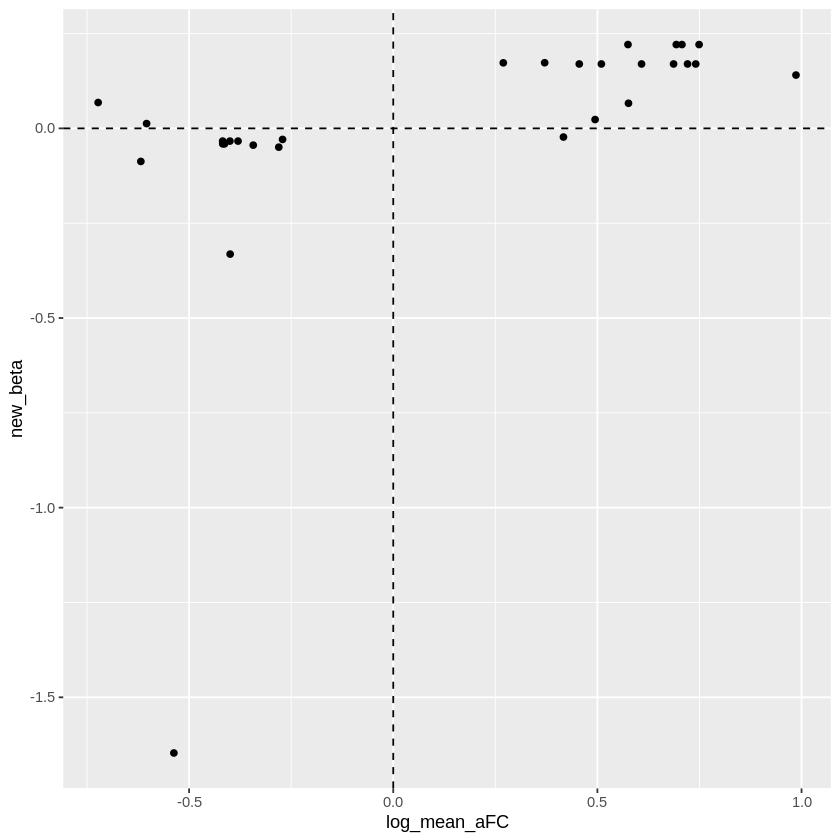

In [39]:
# How are they in our "new" eQTL study? (has new_eQTL_beta_wrt_ALT)
setnames(our_eqtls, "beta", "new_beta", skip_absent=TRUE)

setkey(our_eqtls, SNP, ensembl_gid)
sig_wSNPs_our_eqtls <- resprox_dpn[our_eqtls, on = c(BaseQTL_SNP_hg19 = "SNP", ENSG_ID = "ensembl_gid"), nomatch = NULL]
sig_wSNPs_our_eqtls[log_mean_aFC < 0 & new_beta < 0, direction_new_eQTLvsLooping := "same"]
sig_wSNPs_our_eqtls[log_mean_aFC > 0 & new_beta > 0, direction_new_eQTLvsLooping := "same"]
sig_wSNPs_our_eqtls[log_mean_aFC < 0 & new_beta > 0, direction_new_eQTLvsLooping := "different"]
sig_wSNPs_our_eqtls[log_mean_aFC > 0 & new_beta < 0, direction_new_eQTLvsLooping := "different"]
simp <- unique(sig_wSNPs_our_eqtls[, .(BaseQTL_SNP_hg19, direction_eQTLvsLooping, direction_new_eQTLvsLooping, new_beta, log_mean_aFC, FDR)])
simp[, is_sig_fdr := FDR < 0.05]

simp # 


#### plot the betas instead. 
plott3 <- unique(sig_wSNPs_our_eqtls [, .(rsid, log_mean_aFC, new_beta)])
pl <- ggplot(plott3, aes(x = log_mean_aFC, y = new_beta)) + geom_point() + geom_hline(yintercept = 0, linetype = "dashed") +
  geom_vline(xintercept = 0, linetype = "dashed")
pl

###### 

In [8]:
#### To make some sense of the significant looping proxies, make a table of overlaps with other features.
#### NOW - integrating Blueprint histone modifications.
#### Just keep Vosa direction.
### simplify the sig looping table, with new eQTL betas. Include all SNPs that went into the looping analysis.}

#chic_at_LD_tab_small2 has DpnII IDs and the chic data already overlapped with ATAC seq.

## Take only ATAC peaks within 5kb and then take the closest.
at_chic_rna1 <- copy(chic_at_LD_tab_small2)
# OR:
#at_chic_rna1 <- fread("./AT_CHiC_with_LD_SNPs_and_MikBetas_Signif99.txt")

at_chic_rna1[, hg38Proxy_pos := tstrsplit(hrc_hg38Proxy_ID, split = ":", keep = 2, type.convert = T)]
at_chic_rna1[, at_featStart := as.numeric(at_featStart)]
at_chic_rna1[, at_featEnd := as.numeric(at_featEnd)]
at_chic_rna1[, at_mid := at_featStart+(at_featEnd-at_featStart)/2]
at_chic_rna1[, SNP_at_dist := abs(at_mid-hg38Proxy_pos)]

at_chic_rna <- as.data.table(at_chic_rna1 %>% group_by(BaseQTL_SNP_hg19) %>%
                                      mutate(closest_atPeak = min(SNP_at_dist, na.rm = T))) # mutate, not summarize
#unique(at_chic_rna[Gene == "NAAA", .(at_mid, hg38Proxy_pos, closest_atPeak)])

at_chic_rna[SNP_at_dist <= 5000 & closest_atPeak == SNP_at_dist, closest_at_log_aFC := mean(at_log_mean_aFC), by = rsid] # take the mean for all SNP assopciations in LD for that peak
#at_chic_rna[Gene == "NAAA"]
#unique(at_chic_rna[Gene == "C7orf50", .(rsid, chic_log_mean_aFC, at_log_mean_aFC, closest_at_log_aFC)])
#unique(at_chic_rna[Gene == "THBS1", .(at_featStart)])
#str(at_chic_rna)

Warning message in min(SNP_at_dist, na.rm = T):
“no non-missing arguments to min; returning Inf”
Warning message in min(SNP_at_dist, na.rm = T):
“no non-missing arguments to min; returning Inf”


In [9]:
# Continue, making ATAC and RNA beta relative to chic
at_chic_rna[, c("Chr", "hg19Proxy_pos") := tstrsplit(hg19Proxy_ID, split = ":", keep = c(1,2))]
###################################################################
at_chic_rna[Gene == "KCNK13", relative_Gene_Expression_Beta := 0.41]
###################################################################
setnames(at_chic_rna, c("BaseQTL_SNP_hg19", "Beta"), c("BaseQTL_hg19Proxy_ID", "Gene_Expression_Beta"))
at_chic_rna[, BaseQTL_feature := paste(BaseQTL_hg19Proxy_ID, ENSG_ID, Gene, sep = "_")]
at_chic_rna[, abs_chic_log_mean_aFC := abs(chic_log_mean_aFC)]
at_chic_rna[chic_log_mean_aFC > 0, relative_abs_ATAC_mean_aFC := closest_at_log_aFC]
at_chic_rna[chic_log_mean_aFC < 0, relative_abs_ATAC_mean_aFC := 0-closest_at_log_aFC]
at_chic_rna[chic_log_mean_aFC > 0, relative_Gene_Expression_Beta := Gene_Expression_Beta]
at_chic_rna[chic_log_mean_aFC < 0, relative_Gene_Expression_Beta := 0-Gene_Expression_Beta]

###R Check against EGA results}
### Read in data from Blueprint WP10 Phase 2
## EGAF00002542662 mono psiQTL
## EGAF00002542667 mono K27ac
## EGAF00002542671 mono eQTL
## EGAF00002542672 mono meth
## EGAF00002542676 mono K4me1
# Note that the SNP positions are in hg19 assembley.

# Make a function for joining with EGA files. Now joining on the SNPs in LD: based on chr:position
join_ega <- function(loopQTLs, EGAQTLs) {
  # get only significant QTLs and get chr/hg19pos
  #sig_ega <- EGAQTLs[Bonferroni.p < 0.05] # Actually, just try with all top associations
  EGAQTLs[, c("Chr", "to_sep") := tstrsplit(chr.pos_ref_alt, split = ":", fixed = TRUE)]
  EGAQTLs[, c("hg19Proxy_pos", "REF", "ALT") := tstrsplit(to_sep, split = "_", fixed = TRUE)]
  ega_short <- EGAQTLs[, .(Chr, hg19Proxy_pos, chr.pos_ref_alt, phenotypeID, beta, Bonferroni.p)]
  # Make a column showing the direction of effect
  ega_short[beta < 0, ALTeffect := "minus"][beta > 0, ALTeffect := "plus"]
    
  #ega_short[, beta := NULL]
  # Make the col names unique to that phenotype
  pheno_name <- deparse(substitute(EGAQTLs))
  new_snp_name <- paste(pheno_name, "SNP", sep = "_")
  new_pheno_ID <- paste(pheno_name, "phenotypeID", sep = "_")
  new_beta <- paste(pheno_name, "beta", sep = "_")
  new_bonferroni <- paste(pheno_name, "Bonferroni.p", sep = "_")
  new_ALTeffect <- paste(pheno_name, "ALTeffect", sep = "_")
  setnames(ega_short, c("beta", "chr.pos_ref_alt", "phenotypeID", "ALTeffect", "Bonferroni.p"), c(new_beta, new_snp_name, new_pheno_ID, new_ALTeffect, new_bonferroni))
  
  # Join with loopingQTLs based on Chr and hg19 pos
  # The caveat is that the alleles may not match between cohorts. Check the "SNP" column for this.
  joined <- ega_short[loopQTLs, on = c("Chr", "hg19Proxy_pos")]
  return(joined)
}

In [10]:
### H3K27ac
h3k27ac <- fread("~/spivakov/EGA/EGAD00001005200/EGAF00002542667/mono_K27AC_log2rpm_31052017_bedmap_peer_10_summary.Beta_changed.SE.Eigen.pval.txt")
prox_27ac <- join_ega(at_chic_rna, h3k27ac) # Three significant looping loci (7 snps) are also H3K27ac SNPs!
prox_27ac[is.na(h3k27ac_ALTeffect), h3k27ac_ALTeffect := "none"]

###

In [12]:
### H3K4me1
h3k4me1 <- fread("~/spivakov/EGA/EGAD00001005200/EGAF00002542676/mono_K4ME1_log2rpm_31052017_bedmap_peer_10_summary.Beta_changed.SE.Eigen.pval.txt")
prox_27ac_me1 <- join_ega(prox_27ac, h3k4me1) # Two looping SNPs are also H3K4me1 QTLs and also are H3K27ac QTLs. mostly all plus. 
prox_27ac_me1[is.na(h3k4me1_ALTeffect), h3k4me1_ALTeffect := "none"]

write.table(prox_27ac_me1, file = "~/HRJ_monocytes/BaseQTL/findings_round2_dpnIICorrection/blueprint_table_27ac_me1_sig99_LD.txt", sep = "\t", quote = FALSE, row.names = FALSE, col.names = TRUE)

###
#str(prox_27ac_me1)

Warning message:
“package ‘pheatmap’ was built under R version 4.1.3”


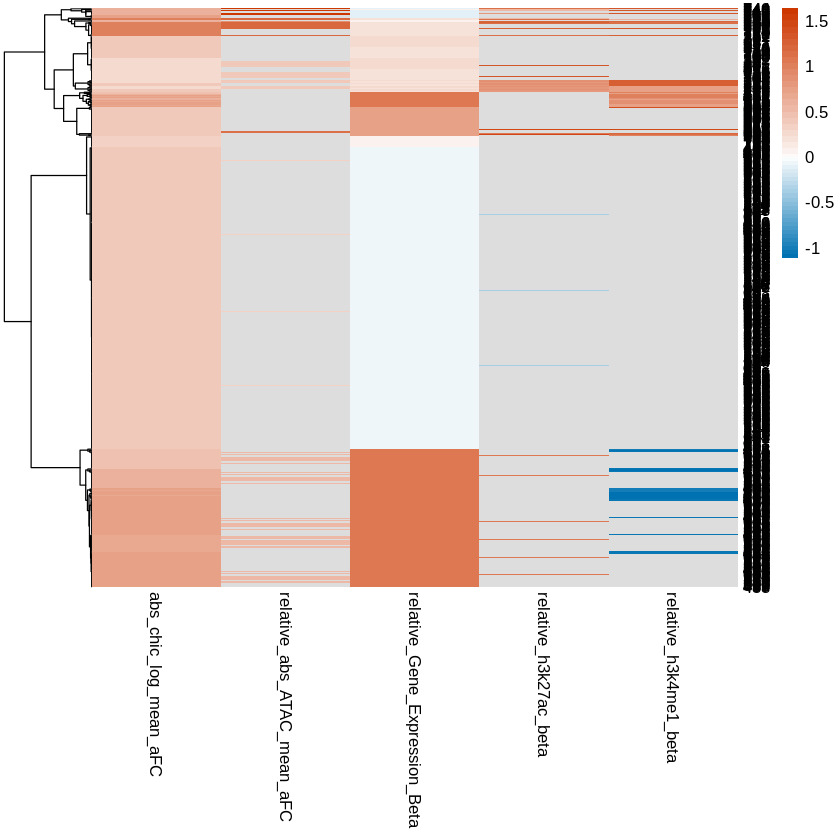

In [8]:
###### CAN GO FROM HERE
### first, draw a heatmap for everything and see if there are any opposing effects within the histone modifications
library(pheatmap)
library(RColorBrewer)
library(data.table)
library(dplyr)

setwd("~/HRJ_monocytes/BaseQTL/findings_round2_dpnIICorrection/")

prox_27ac_me1 <- fread("~/HRJ_monocytes/BaseQTL/findings_round2_dpnIICorrection/blueprint_table_27ac_me1_sig99_LD.txt")
# make DpnII fragment starts unique (there are two starts the same, on different chromosomes)
prox_27ac_me1[, hg38Dpn_start := paste(Chr, hg38Dpn_start, sep = "_")]

## Normalise everything to the chic beta
prox_27ac_me1[chic_log_mean_aFC > 0, relative_h3k27ac_beta := h3k27ac_beta]
prox_27ac_me1[chic_log_mean_aFC < 0, relative_h3k27ac_beta := 0-h3k27ac_beta]
prox_27ac_me1[chic_log_mean_aFC > 0, relative_h3k4me1_beta := h3k4me1_beta]
prox_27ac_me1[chic_log_mean_aFC < 0, relative_h3k4me1_beta := 0-h3k4me1_beta]

matrix_prep <- copy(prox_27ac_me1)
### Heatmap is better?
matrix_prep[, ID := paste(rsid, Gene, sep = "_")]
matrix_prep[, proxID := rownames(matrix_prep)]

mat <- as.data.frame(matrix_prep[, .(proxID, abs_chic_log_mean_aFC, relative_abs_ATAC_mean_aFC, relative_Gene_Expression_Beta, relative_h3k27ac_beta, relative_h3k4me1_beta)])
rownames(mat) <- mat[,1]
mat2 <- mat[ -c(1) ]

# make sure center is at zero
paletteLength <- 50
myColor <- colorRampPalette(c("#0072B2", "white", "orangered3"))(paletteLength)
# length(breaks) == length(paletteLength) + 1
# use floor and ceiling to deal with even/odd length pallettelengths
myBreaks <- c(seq(min(mat2, na.rm=T), 0, length.out=ceiling(paletteLength/2) + 1), 
              seq(max(mat2, na.rm=T)/paletteLength, max(mat2, na.rm=T), length.out=floor(paletteLength/2)))


pheatmap(mat2, cluster_rows = TRUE, cluster_cols = F, color = myColor, breaks=myBreaks)

In [9]:
### Take the histone modification that is closest to the baseQTL contact QTL.

matrix_prep[, BaseQTL_hg19Proxy_pos := tstrsplit(BaseQTL_hg19Proxy_ID, split = ":", keep = 2, type.convert = T)] #because hg19Proxy_pos in this table refers to the SNP in LD

matrix_prep[, c("h3k27ac_start", "h3k27ac_end") := tstrsplit(h3k27ac_phenotypeID, split = ":", keep = c(2,3), type.convert = T)]
matrix_prep[, h3k27ac_mid := h3k27ac_start+(h3k27ac_end-h3k27ac_start)/2]
matrix_prep[, SNP_27ac_dist := abs(h3k27ac_mid-BaseQTL_hg19Proxy_pos)] # these features are in hg19!
matrix_prep[, SNP_27ac_Startdist := abs(h3k27ac_start-BaseQTL_hg19Proxy_pos)] # somtimes the peak is very large
matrix_prep[, SNP_27ac_Enddist := abs(h3k27ac_end-BaseQTL_hg19Proxy_pos)] # sometimes the peak is very large


matrix_prep[, c("h3k4me1_start", "h3k4me1_end") := tstrsplit(h3k4me1_phenotypeID, split = ":", keep = c(2,3), type.convert = T)]
matrix_prep[, h3k4me1_mid := h3k4me1_start+(h3k4me1_end-h3k4me1_start)/2]
matrix_prep[, SNP_me1_dist := abs(h3k4me1_mid-BaseQTL_hg19Proxy_pos)]
matrix_prep[, SNP_me1_Startdist := abs(h3k4me1_start-BaseQTL_hg19Proxy_pos)]
matrix_prep[, SNP_me1_Enddist := abs(h3k4me1_end-BaseQTL_hg19Proxy_pos)]


new_matrix_prep <- unique(matrix_prep[, .(Chr, proxID, ID, hg19Proxy_ID, hg38Proxy_pos, BaseQTL_hg19Proxy_ID, rsid, BaseQTL_hg19Proxy_pos, abs_chic_log_mean_aFC, relative_abs_ATAC_mean_aFC, relative_Gene_Expression_Beta, relative_h3k27ac_beta, relative_h3k4me1_beta, 
                                  h3k27ac_mid, h3k4me1_mid, SNP_27ac_dist, SNP_27ac_Startdist, SNP_27ac_Enddist, SNP_me1_dist, SNP_me1_Startdist, SNP_me1_Enddist, hg38Dpn_start)])

new_matrix_prep27ac <- as.data.table(new_matrix_prep %>% group_by(BaseQTL_hg19Proxy_pos) %>%
                                      mutate(closest_27acPeak = min(SNP_27ac_dist, na.rm = T))) # mutate, not summarize
new_matrix_prep27ac[SNP_27ac_dist <= 5000 & closest_27acPeak == SNP_27ac_dist | SNP_27ac_Startdist <= 5000 & closest_27acPeak == SNP_27ac_dist | 
                    SNP_27ac_Enddist <= 5000 & closest_27acPeak == SNP_27ac_dist, closest_relative_h3k27ac_beta := mean(relative_h3k27ac_beta), by = rsid] # take an average, because the association is for the same peak but with different SNPs.


new_matrix_prepme1 <- as.data.table(new_matrix_prep27ac %>% group_by(BaseQTL_hg19Proxy_pos) %>%
                                      mutate(closest_me1Peak = min(SNP_me1_dist, na.rm = T))) # mutate, not summarize
new_matrix_prepme1[SNP_me1_dist <= 5000 & closest_me1Peak == SNP_me1_dist | SNP_me1_Startdist <= 5000 & closest_me1Peak == SNP_me1_dist |
                   SNP_me1_Enddist <= 5000 & closest_me1Peak == SNP_me1_dist, closest_relative_h3k4me1_beta := mean(relative_h3k4me1_beta), by = rsid] # take an average, because the association is for the same peak but with different SNPs.



# this table should then be as long as the no. of BaseQTL CHiC SNPs: 
mat_prep_final <- unique(new_matrix_prepme1[, .(Chr, ID, hg38Dpn_start, BaseQTL_hg19Proxy_pos, abs_chic_log_mean_aFC, relative_abs_ATAC_mean_aFC, relative_Gene_Expression_Beta, closest_relative_h3k27ac_beta, closest_relative_h3k4me1_beta)])
#mat_prep_final

# collapse rows
mat_prep_final_collapsed <- as.data.table(mat_prep_final %>% group_by(ID, Chr, BaseQTL_hg19Proxy_pos, hg38Dpn_start) %>% summarise_each(funs(sum(., na.rm = TRUE)))) # https://stackoverflow.com/questions/28036294/collapsing-rows-where-some-are-all-na-others-are-disjoint-with-some-nas
setorder(mat_prep_final_collapsed, Chr, BaseQTL_hg19Proxy_pos)
mat_prep_final_collapsed[, c("Chr", "BaseQTL_hg19Proxy_pos") := NULL]
#####\
mat_prep_final_collapsed

Warning message in min(SNP_27ac_dist, na.rm = T):
“no non-missing arguments to min; returning Inf”
Warning message in min(SNP_27ac_dist, na.rm = T):
“no non-missing arguments to min; returning Inf”
Warning message in min(SNP_me1_dist, na.rm = T):
“no non-missing arguments to min; returning Inf”
Warning message in min(SNP_me1_dist, na.rm = T):
“no non-missing arguments to min; returning Inf”
Warning message in min(SNP_me1_dist, na.rm = T):
“no non-missing arguments to min; returning Inf”
Warning message in min(SNP_me1_dist, na.rm = T):
“no non-missing arguments to min; returning Inf”
Warning message in min(SNP_me1_dist, na.rm = T):
“no non-missing arguments to min; returning Inf”
Warning message in min(SNP_me1_dist, na.rm = T):
“no non-missing arguments to min; returning Inf”
Warning message:
“`summarise_each_()` was deprecated in dplyr 0.7.0.
ℹ Please use `across()` instead.
ℹ The deprecated feature was likely used in the dplyr package.
  Please report the issue at <https://github.com/

ID,hg38Dpn_start,abs_chic_log_mean_aFC,relative_abs_ATAC_mean_aFC,relative_Gene_Expression_Beta,closest_relative_h3k27ac_beta,closest_relative_h3k4me1_beta
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs13150842_NAAA,4_75894747,1.4835395,0.0000000,0.94969145,0.000000,2.596098
rs11731367_NAAA,4_75896038,2.1564535,2.3941331,1.89938289,2.706474,2.596098
rs7798572_C7orf50,7_1171069,0.7603511,0.3645636,-0.11534927,0.000000,0.000000
rs7784502_C7orf50,7_1171069,0.8352169,0.3645636,-0.11534927,0.000000,0.000000
rs2960849_C7orf50,7_1171069,0.8355758,0.3645636,-0.11534927,0.000000,0.000000
rs2960848_C7orf50,7_1171069,0.8267120,0.3645636,-0.11534927,0.000000,0.000000
rs35257100_NFE2L3,7_26095447,1.5975826,1.1094288,2.93967167,2.936485,1.488365
rs3006562_SVIL,10_29802980,4.9317607,4.8123701,0.83990252,2.559730,2.646320
rs4568912_PTPRE,10_128084364,0.3429079,0.0000000,0.04662117,0.000000,0.000000


In [10]:
###### check C7orf50. were there further effects on histones?

setwd("~/HRJ_monocytes/BaseQTL/findings_round2_dpnIICorrection/")

prox_27ac_me1 <- fread("~/HRJ_monocytes/BaseQTL/findings_round2_dpnIICorrection/blueprint_table_27ac_me1_sig99_LD.txt")
# mak

prox_27ac_me1[BaseQTL_feature %like% "C7orf50" & !is.na(h3k4me1_beta)]
prox_27ac_me1[BaseQTL_feature %like% "C7orf50" & !is.na(h3k27ac_beta)]

### there was an effect on 27ac

# make DpnII fragment starts unique (there are two starts the same, on different chromosomes)
prox_27ac_me1[, hg38Dpn_start := paste(Chr, hg38Dpn_start, sep = "_")]

## Normalise everything to the chic beta
prox_27ac_me1[chic_log_mean_aFC > 0, relative_h3k27ac_beta := h3k27ac_beta]
prox_27ac_me1[chic_log_mean_aFC < 0, relative_h3k27ac_beta := 0-h3k27ac_beta]
prox_27ac_me1[chic_log_mean_aFC > 0, relative_h3k4me1_beta := h3k4me1_beta]
prox_27ac_me1[chic_log_mean_aFC < 0, relative_h3k4me1_beta := 0-h3k4me1_beta]

prox_27ac_me1[, BaseQTL_hg19Proxy_pos := tstrsplit(BaseQTL_hg19Proxy_ID, split = ":", keep = 2, type.convert = T)] #because hg19Proxy_pos in this table refers to the SNP in LD

prox_27ac_me1[, c("h3k27ac_start", "h3k27ac_end") := tstrsplit(h3k27ac_phenotypeID, split = ":", keep = c(2,3), type.convert = T)]
prox_27ac_me1[, h3k27ac_mid := h3k27ac_start+(h3k27ac_end-h3k27ac_start)/2]
prox_27ac_me1[, SNP_27ac_dist := abs(h3k27ac_mid-BaseQTL_hg19Proxy_pos)] # these features are in hg19!
prox_27ac_me1[, SNP_27ac_Startdist := abs(h3k27ac_start-BaseQTL_hg19Proxy_pos)] # somtimes the peak is very large
prox_27ac_me1[, SNP_27ac_Enddist := abs(h3k27ac_end-BaseQTL_hg19Proxy_pos)] # sometimes the peak is very large

### how far was the peak?

peak_check <- prox_27ac_me1[BaseQTL_feature %like% "C7orf50" & !is.na(h3k27ac_beta)]
peak_check[, .(Chr, SNP_27ac_dist, SNP_27ac_Startdist, SNP_27ac_Enddist, h3k27ac_mid, h3k27ac_phenotypeID, relative_Gene_Expression_Beta, relative_abs_ATAC_mean_aFC, chic_log_mean_aFC, relative_h3k27ac_beta, relative_Gene_Expression_Beta)]
peak_check2 <- prox_27ac_me1[BaseQTL_feature %like% "C7orf50"]
peak_check2[!is.na(relative_abs_ATAC_mean_aFC), .(Chr, SNP_27ac_dist, SNP_27ac_Startdist, SNP_27ac_Enddist, h3k27ac_mid, h3k27ac_phenotypeID, relative_Gene_Expression_Beta, relative_abs_ATAC_mean_aFC, chic_log_mean_aFC, relative_h3k27ac_beta, relative_Gene_Expression_Beta)]


#str(prox_27ac_me1)

Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


Chr,hg19Proxy_pos,h3k4me1_SNP,h3k4me1_phenotypeID,h3k4me1_beta,h3k4me1_Bonferroni.p,h3k4me1_ALTeffect,h3k27ac_SNP,h3k27ac_phenotypeID,h3k27ac_beta,⋯,at_chic_dir,hg38Proxy_pos,at_mid,SNP_at_dist,closest_atPeak,closest_at_log_aFC,relative_Gene_Expression_Beta,BaseQTL_feature,abs_chic_log_mean_aFC,relative_abs_ATAC_mean_aFC
<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>


Chr,hg19Proxy_pos,h3k4me1_SNP,h3k4me1_phenotypeID,h3k4me1_beta,h3k4me1_Bonferroni.p,h3k4me1_ALTeffect,h3k27ac_SNP,h3k27ac_phenotypeID,h3k27ac_beta,⋯,at_chic_dir,hg38Proxy_pos,at_mid,SNP_at_dist,closest_atPeak,closest_at_log_aFC,relative_Gene_Expression_Beta,BaseQTL_feature,abs_chic_log_mean_aFC,relative_abs_ATAC_mean_aFC
<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
7,1199804,NA,NA,NA,NA,none,7:1199804_C_T,7:2023512:2030487,0.3985703,⋯,NA,1171119,NA,NA,1209,NA,-0.05767463,7:1210755:C:T_ENSG00000146540_C7orf50,0.3801756,NA
7,1199804,NA,NA,NA,NA,none,7:1199804_C_T,7:2023512:2030487,0.3985703,⋯,NA,1171262,NA,NA,1352,NA,-0.05767463,7:1210898:G:A_ENSG00000146540_C7orf50,0.4176084,NA
7,1199804,NA,NA,NA,NA,none,7:1199804_C_T,7:2023512:2030487,0.3985703,⋯,NA,1172342,NA,NA,2432,NA,-0.05767463,7:1211978:C:G_ENSG00000146540_C7orf50,0.4177879,NA
7,1199804,NA,NA,NA,NA,none,7:1199804_C_T,7:2023512:2030487,0.3985703,⋯,NA,1172575,NA,NA,2665,NA,-0.05767463,7:1212211:C:A_ENSG00000146540_C7orf50,0.4133560,NA


Chr,SNP_27ac_dist,SNP_27ac_Startdist,SNP_27ac_Enddist,h3k27ac_mid,h3k27ac_phenotypeID,relative_Gene_Expression_Beta,relative_abs_ATAC_mean_aFC,chic_log_mean_aFC,relative_h3k27ac_beta,relative_Gene_Expression_Beta
<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,816244.5,812757,819732,2027000,7:2023512:2030487,-0.05767463,NA,-0.3801756,-0.3985703,-0.05767463
7,816101.5,812614,819589,2027000,7:2023512:2030487,-0.05767463,NA,-0.4176084,-0.3985703,-0.05767463
7,815021.5,811534,818509,2027000,7:2023512:2030487,-0.05767463,NA,-0.4177879,-0.3985703,-0.05767463
7,814788.5,811301,818276,2027000,7:2023512:2030487,-0.05767463,NA,-0.4133560,-0.3985703,-0.05767463


Chr,SNP_27ac_dist,SNP_27ac_Startdist,SNP_27ac_Enddist,h3k27ac_mid,h3k27ac_phenotypeID,relative_Gene_Expression_Beta,relative_abs_ATAC_mean_aFC,chic_log_mean_aFC,relative_h3k27ac_beta,relative_Gene_Expression_Beta
<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,NA,NA,NA,NA,NA,-0.05767463,0.3645636,-0.3801756,NA,-0.05767463
7,NA,NA,NA,NA,NA,-0.05767463,0.3645636,-0.4176084,NA,-0.05767463
7,NA,NA,NA,NA,NA,-0.05767463,0.3645636,-0.4177879,NA,-0.05767463
7,NA,NA,NA,NA,NA,-0.05767463,0.3645636,-0.4133560,NA,-0.05767463
7,NA,NA,NA,NA,NA,-0.05767463,0.3645636,-0.3801756,NA,-0.05767463
7,NA,NA,NA,NA,NA,-0.05767463,0.3645636,-0.4176084,NA,-0.05767463
7,NA,NA,NA,NA,NA,-0.05767463,0.3645636,-0.4177879,NA,-0.05767463
7,NA,NA,NA,NA,NA,-0.05767463,0.3645636,-0.4133560,NA,-0.05767463


png 
  2

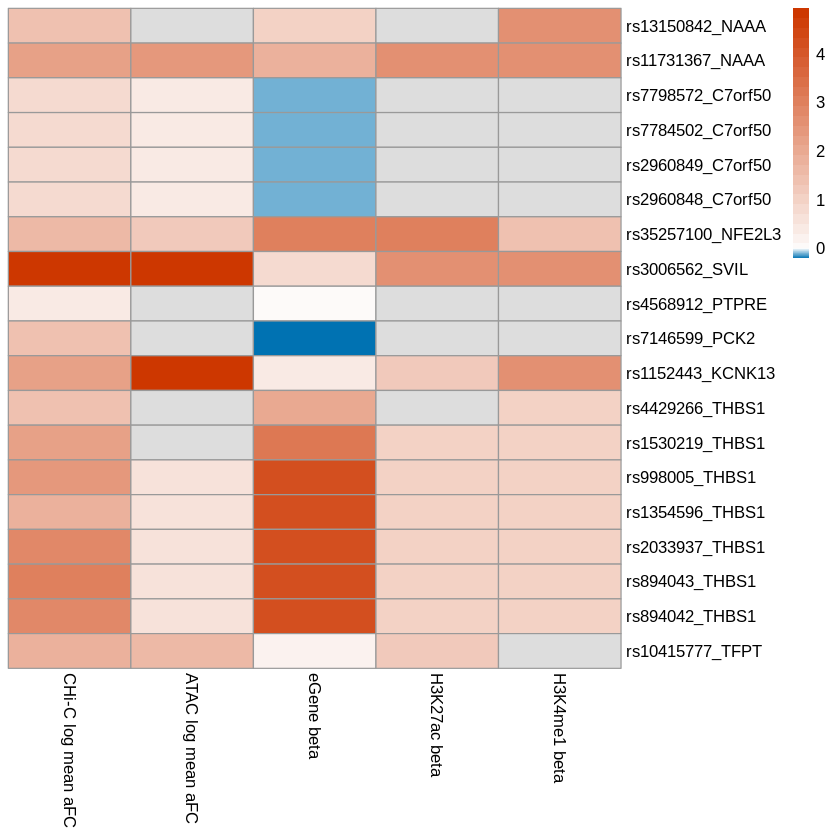

In [11]:
matrix_prep4 <- copy(mat_prep_final_collapsed)
###################################################################
matrix_prep4[ID == "rs1152443_KCNK13", relative_Gene_Expression_Beta := 0.41]
#matrix_prep4[ID == "rs1152443_KCNK13", ID := "rs1152443_KCNK13*"]
###################################################################
setnames(matrix_prep4, c("abs_chic_log_mean_aFC", "relative_Gene_Expression_Beta", "relative_abs_ATAC_mean_aFC", "closest_relative_h3k27ac_beta", "closest_relative_h3k4me1_beta"), 
        c("CHi-C log mean aFC", "eGene beta", "ATAC log mean aFC", "H3K27ac beta", "H3K4me1 beta"))

# Set zero to NA
matrix_prep4[`ATAC log mean aFC` == 0, `ATAC log mean aFC` := NA]
matrix_prep4[`H3K27ac beta` == 0, `H3K27ac beta` := NA]
matrix_prep4[`H3K4me1 beta` == 0, `H3K4me1 beta` := NA]

mat <- as.data.frame(matrix_prep4[, .(ID, `CHi-C log mean aFC`, `ATAC log mean aFC`, `eGene beta`, `H3K27ac beta`, `H3K4me1 beta`)])
rownames(mat) <- mat[,1]
mat2 <- mat[ -c(1) ]

# make sure center is at zero
paletteLength <- 50
myColor <- colorRampPalette(c("#0072B2", "white", "orangered3"))(paletteLength)
# length(breaks) == length(paletteLength) + 1
# use floor and ceiling to deal with even/odd length pallettelengths
myBreaks <- c(seq(min(mat2, na.rm=T), 0, length.out=ceiling(paletteLength/2) + 1), 
              seq(max(mat2, na.rm=T)/paletteLength, max(mat2, na.rm=T), length.out=floor(paletteLength/2)))

####### TO CHECK: C7ORF50 27AC AND THBS1 ME1 

save_pheatmap_pdf <- function(x, filename, width=6, height=6) {
    stopifnot(!missing(x))
    stopifnot(!missing(filename))
    pdf(filename, width=width, height=height)
    grid::grid.newpage()
    grid::grid.draw(x$gtable)
    dev.off()
}

p <- pheatmap(mat2, cluster_rows = F, cluster_cols = F, color = myColor, breaks=myBreaks)
save_pheatmap_pdf(p, "~/HRJ_monocytes/paper/Signif.99_plusBlueprint_heatmap_noMethyl_LD.pdf")


,CHi-C,ATAC,eGene,H3K27ac,H3K4me1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs13150842_NAAA,1,NA,1,NA,1
rs11731367_NAAA,1,1,1,1,1
rs7798572_C7orf50,1,1,-1,NA,NA
rs7784502_C7orf50,1,1,-1,NA,NA
rs2960849_C7orf50,1,1,-1,NA,NA
rs2960848_C7orf50,1,1,-1,NA,NA
rs35257100_NFE2L3,1,1,1,1,1
rs3006562_SVIL,1,1,1,1,1
rs4568912_PTPRE,1,NA,1,NA,NA


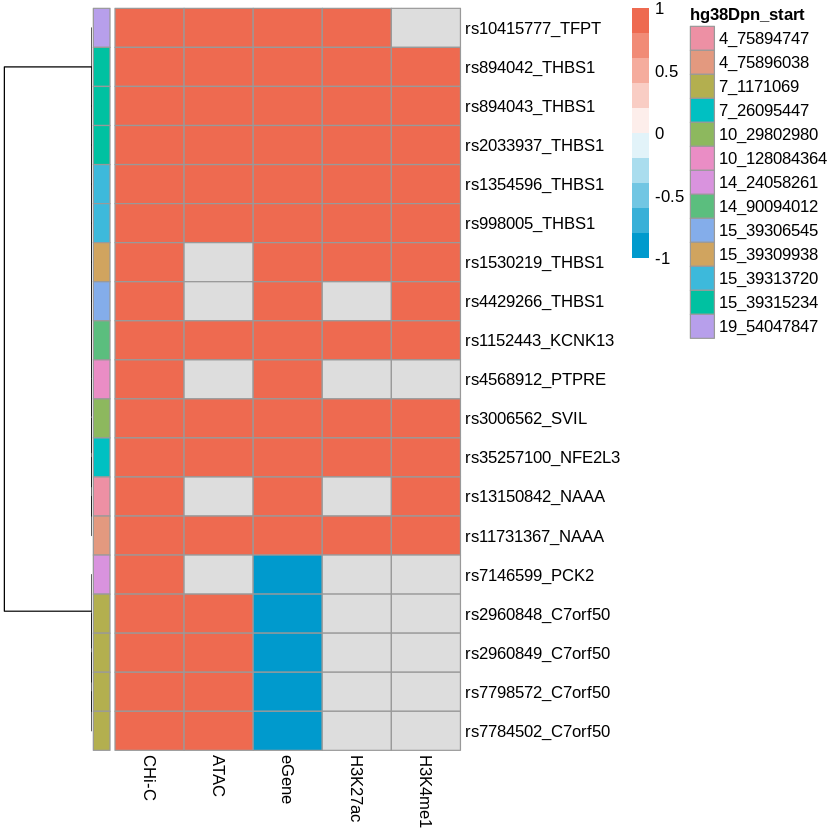

In [15]:
#### Make a binary heatmap.
#### Include DpnII fragments as an annotation column.

my_dpnII_frags <- unique(matrix_prep4[, .(ID, hg38Dpn_start)])
my_dpnII_frags[, ID := NULL]
my_dpnII_frags[, hg38Dpn_start := as.factor(hg38Dpn_start)]

matrix_prep5 <- matrix_prep4[, .(ID, `CHi-C log mean aFC`, `ATAC log mean aFC`, `eGene beta`, `H3K27ac beta`, `H3K4me1 beta`)]

matrix_prep5[`CHi-C log mean aFC` > 0, `CHi-C` := 1]
matrix_prep5[`ATAC log mean aFC` > 0, `ATAC` := 1]
matrix_prep5[`eGene beta` > 0, `eGene` := 1]
matrix_prep5[`eGene beta` < 0, `eGene` := -1]
matrix_prep5[`H3K27ac beta` > 0, `H3K27ac` := 1]
matrix_prep5[`H3K4me1 beta` > 0, `H3K4me1` := 1]

matrix_prep6 <- matrix_prep5[, .(ID, `CHi-C`, ATAC, eGene, H3K27ac, H3K4me1)]

mat <- as.data.frame(matrix_prep6)
rownames(mat) <- mat[,1]
mat2 <- mat[ -c(1) ]

# Make rows of DpnII frags the colnames of matrix
my_dpnII_frags_annot <- as.data.frame(my_dpnII_frags)
rownames(my_dpnII_frags_annot) <- rownames(mat2)

# draw the heatmap with row and column annotations

# make sure center is at zero
paletteLength <- 50
myColor <- colorRampPalette(c("#0072B2", "white", "orangered3"))(paletteLength)
# length(breaks) == length(paletteLength) + 1
# use floor and ceiling to deal with even/odd length pallettelengths
myBreaks <- c(seq(min(mat2, na.rm=T), 0, length.out=ceiling(paletteLength/2) + 1), 
              seq(max(mat2, na.rm=T)/paletteLength, max(mat2, na.rm=T), length.out=floor(paletteLength/2)))

save_pheatmap_pdf <- function(x, filename, width=6, height=6) {
    stopifnot(!missing(x))
    stopifnot(!missing(filename))
    pdf(filename, width=width, height=height)
    grid::grid.newpage()
    grid::grid.draw(x$gtable)
    dev.off()
}

paletteLength <- 10
myColor <- colorRampPalette(c("deepskyblue3", "white", "coral2"))(paletteLength)
#annotColor <- brewer.pal(n = 7, name = "Paired")))(paletteLength) need to make nicer
# code for changing color pallete:
newCols <- colorRampPalette(grDevices::hcl.colors(length(unique(my_dpnII_frags_annot$hg38Dpn_start)), 
                                                 palette = "Set2"))
mycolors <- newCols(length(unique(my_dpnII_frags_annot$hg38Dpn_start)))
shuf_mycolors <- sample(mycolors)
names(shuf_mycolors) <- unique(my_dpnII_frags_annot$hg38Dpn_start)
shuf_mycolors <- list(hg38Dpn_start = shuf_mycolors)

p <- pheatmap(mat2, cluster_rows = T, cluster_cols = F, annotation_row = my_dpnII_frags_annot, annotation_names_row = F, annotation_legend = T, 
              color = myColor, annotation_colors = shuf_mycolors) # to add: annotation_colors = annotColor, 
#save_pheatmap_pdf(p, "~/HRJ_monocytes/paper/Signif.99_plusBlueprint_heatmap_noMethyl_LD.pdf")

mat2

# Save matrix_prep5 for source data, which has the beta values as well as plus/minus.
fwrite(matrix_prep5, file = "~/HRJ_monocytes/paper/source_data/Fig3C_matrix.txt", 
      sep = "\t", quote = F, row.names = F, col.names = T)


In [10]:
my_dpnII_frags_annot

,hg38Dpn_start
,<fct>
rs13150842_NAAA,4_75894747
rs11731367_NAAA,4_75896038
rs7798572_C7orf50,7_1171069
rs7784502_C7orf50,7_1171069
rs2960849_C7orf50,7_1171069
rs2960848_C7orf50,7_1171069
rs35257100_NFE2L3,7_26095447
rs3006562_SVIL,10_29802980
rs4568912_PTPRE,10_128084364
